In [331]:
# General purpose
import pandas as pd
import os
import glob
import json
import numpy as np
from ast import literal_eval
import string
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
import itertools
from numpy.linalg import norm
from collections import Counter
import codecs
import tqdm
import scipy as sp
# NLP
from cade.cade import CADE
from gensim.models.word2vec import Word2Vec
# Machine Learning
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.model_selection import cross_val_score
# currently installed theme will be used to
# set plot style if no arguments provided
# Theme
from jupyterthemes import jtplot
jtplot.style()

In [2]:
# Function to remove punctuation from strings.
# Copied from Prof.
def simple_preproc(text):
  """
  see: https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string
  """
  return text.translate(str.maketrans('', '', string.punctuation))

# Pre-processing

Here we load the json arrays from Mongo and output a csv file, i.e. a pandas dataframe. 
This DF will be used for the CADE training.

Provo senza Wikipedia

In [3]:
df_list = pd.DataFrame()
for filename in glob.glob('../data_final/*.json'):
    print(filename)
    with open(filename, 'r') as f:
        json_load = json.loads(f.read())
        df_list = df_list.append(pd.DataFrame.from_records(json_load, index="_id"), ignore_index = True)

./data_final/scraping_data_Breitbart.json
./data_final/scraping_data_NYTimes.json


In [4]:
df_list = df_list[['Title', "Date", "Link", "Paragraphs", "Authors"]]

In [5]:
def create_newssite(link = None):
        if link is np.nan:
            return("Wikipedia")
        elif "slate.com" in link:
            return("Slate")
        elif "https://www.nytimes.com" in link:
            return("New York Times")
        elif "https://www.breitbart.com" in link:
            return("Breitbart")
        elif "https://www.cnn.com" in link:
            return("CNN")
        elif "abcnews" in link:
            return("ABC News")
        elif "https://thefederalist.com" in link:
            return("The Federalist")
        elif "https://www.newsmax.com" in link:
            return("News Max")
        else:
            return("Unknown")

In [6]:
df_list["Newssite"] = df_list["Link"].apply(create_newssite)

if len(df_list[df_list["Newssite"][:] == "Unknown"]) == 0:
    print("AVVOCATO CI SIAMO")

AVVOCATO CI SIAMO


In [7]:
with open("./data_safe.csv", 'w') as file:
    df_list.to_csv(file)

# CADE

## Embedding totale

First, we create a big text with everything. Like, EVERYTHING.

In [8]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')

df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

EVERYTHING = ""
for k in df["Paragraphs"]:
    EVERYTHING += "\n".join(k)

In [9]:
EVERYTHING = simple_preproc(EVERYTHING).lower()
EVERYTHING = EVERYTHING.replace("—", 
                                                "").replace("\n", 
                                                            " ").replace("“", 
                                                                         "").replace("“", 
                                                                                          "").replace("”", 
                                                                                                      "").replace("’s", 
                                                                                                             "")

In [10]:
with open("./EVERYTHING.txt", 'w') as file:
    file.write(EVERYTHING)

In [3]:
aligner = CADE(size=100, workers=12)

aligner.train_compass("./EVERYTHING.txt", overwrite=False) # keep an eye on the overwrite behaviour

Training the compass from scratch.


## Embedding singolo slice

In [4]:
with open("./data_safe.csv") as file:
    df = pd.read_csv(file, engine='c')
    
df["Paragraphs"] = df["Paragraphs"].apply(literal_eval)

for i, Newssite in enumerate(df["Newssite"].unique()):
    print("[INFO] Progress:"+str(i+1)+"/"+str(len(df["Newssite"].unique())))
    newssite_to_text = ""
    for k in df[df["Newssite"] == Newssite]["Paragraphs"][:]:
        newssite_to_text += "\n".join(k)
    newssite_to_text = simple_preproc(newssite_to_text).lower()
    newssite_to_text = newssite_to_text.replace("—", 
                                                "").replace("\n", 
                                                            " ").replace("“", 
                                                                         "").replace("“", 
                                                                                          "").replace("”", 
                                                                                                      "").replace("’s", 
                                                                                                             "")
    with open("./text_"+str(Newssite)+".txt", 'w') as file:
        file.write(newssite_to_text)

[INFO] Progress:1/2
[INFO] Progress:2/2


In [5]:
slices = {
            Newssite: aligner.train_slice("./text_"+str(Newssite)+".txt", save=False)
            for Newssite in df["Newssite"].unique()
         }

Training embeddings: slice ./text_Breitbart.txt.
Initializing embeddings from compass.
Training embeddings: slice ./text_New York Times.txt.
Initializing embeddings from compass.


In [6]:
# Dobbiamo andare a salvare i vari slice
for my_slice in slices:
    slices[my_slice].save("models/"+str(my_slice)+".model")

## Visualizzazione medie

In [48]:
def sum_vectors(my_slice = None):
    my_sum = 0
    for i, word in enumerate(my_slice.wv.vocab):
        my_sum += my_slice.wv[word]
    return(my_sum/len(my_slice.wv.vocab))

In [49]:
my_sum = [sum_vectors(slices[my_slice]) 
       for i, my_slice in enumerate(slices)]

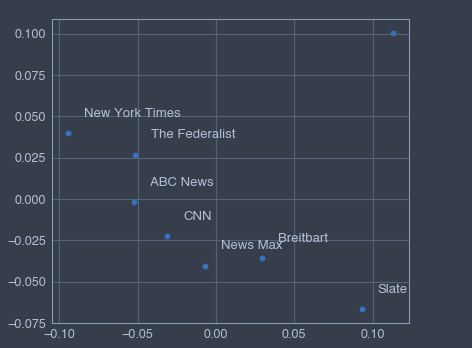

In [50]:
X_tranf = PCA(n_components=2).fit_transform(my_sum)
plt.scatter(X_tranf[:, 0], X_tranf[:, 1])
for index, word in enumerate(slices):
    plt.annotate(word, xy=(X_tranf[index, 0]+0.01, X_tranf[index, 1]+0.01))
plt.show()

In [17]:
print(np.array([[int((1 - cosine(my_sum[j], my_sum[i]))*100)/100
  for j in range(len(slices))] 
 for i in range(len(slices))]))

[[1.   0.93]
 [0.93 1.  ]]


In [18]:
for i, my_slice_1 in enumerate(slices):
    for j, my_slice_2 in enumerate(slices):
        print(i, j)
        print(1 - cosine(my_sum[j], my_sum[i]))

0 0
1.0
0 1
0.9388323426246643
1 0
0.9388323426246643
1 1
1.0


# Lexicon Refinement

In questa sezione andiamo a prendere un Lexicon già [fatto](https://mpqa.cs.pitt.edu/lexicons/subj_lexicon/). Questo possiede due score: noi chiamiamo 0 quello per l'oggettività, e 1 per la soggettività. 

## Pre-processing Lexicon

In [19]:
with open("./lexicon/subjectivityLexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, engine='c', sep=';', header=None)

lexicon.columns = ["Word", "Subj_score"]

# Facciamo un po' di pulizia prima di procedere
lexicon["Word"] = lexicon["Word"].apply(lambda x: x.replace("word1=", ""))
lexicon["Subj_score"] = lexicon["Subj_score"].apply(lambda x: 
                                                    x.replace("type=", ""))

In [20]:
def encode_subj(string_score = None):
    if string_score == "weaksubj":
        return(0)
    elif string_score == "strongsubj":
        return(1)
    else:
        print('[ERROR] Some problems occurd.')
        return(-1)

In [21]:
lexicon["Subj_score"] = lexicon["Subj_score"].apply(encode_subj)

In [22]:
with open("./lexicon/clean_lexicon.csv", 'w') as file:
    lexicon.to_csv(file)

## LRP

In [39]:
from utils import *

In [40]:
# Caricamento del lexicon
with open("./lexicon/clean_lexicon.csv", 'r') as file:
    lexicon = pd.read_csv(file, index_col=1)

# Caricamento dei modelli già addestrati
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [41]:
lexicon = lexicon.drop("Unnamed: 0", axis=1)

lexicon = lexicon.to_dict()["Subj_score"]

In [44]:
# Lessico che si ottiene raffinando su tutti 
# gli embedding generati
lexicon_refined = lexicon_refinement(lex = lexicon, 
                   models = [slices[sli] 
                             for sli in slices], 
                   corpora = ["./text_"+str(sli)+".txt" 
                              for sli in slices], 
                    zipf_cutoff=5)

count text_Wikipedia
min_count text_Wikipedia
zipf text_Wikipedia
count text_ABC News
min_count text_ABC News
zipf text_ABC News
count text_Slate
min_count text_Slate
zipf text_Slate
count text_Breitbart
min_count text_Breitbart
zipf text_Breitbart
count text_CNN
min_count text_CNN
zipf text_CNN
count text_The Federalist
min_count text_The Federalist
zipf text_The Federalist
count text_New York Times
min_count text_New York Times
zipf text_New York Times
count text_News Max
min_count text_News Max
zipf text_News Max
dataframe done
common filter done


In [45]:
with open("./lexicon/lexicon_refined.csv", 'w') as file:
    pd.DataFrame(lexicon_refined).to_csv(file)

## Lexicon Enrichment

Su consiglio di Nicoli, facciamo prima l'arricchimento della classe meno frequente (nel nostro caso quella con `1`). 

Per eseguirla, usiamo una funzione già costruita dal nostro assistente preferito.

In [46]:
# Dobbiamo fare così per come è costruita la funzione di Nicoli
lexicon_refined[lexicon_refined == 0] = -1

In [48]:
vectorized_lexicon, lexicon_labels, words = enrich(lex = lexicon_refined, 
       models = [slices[sl] for sl in slices], 
       n_target = 400, 
       msteps = 200, 
       return_words = True)

  0%|          | 0/36 [00:00<?, ?it/s]

Balancing:  36


  0%|          | 0/306 [00:00<?, ?it/s]

Growing:  306


100%|██████████| 306/306 [03:37<00:00,  1.41it/s]


In [234]:
with open("./lexicon/enriched_lexicon.csv", 'w') as file:
    pd.DataFrame({"Vectorized_words": vectorized_lexicon.tolist(), 
              "Labels": lexicon_labels, "Words": words}).to_csv(file)

# Score Induction Nicoli

La procedura di di Nicoli è quella di applicare una **regressione logistica** usando il lessico aumentato come *training set*. 

**Note**: per la score induction andiamo a usare una *Support Vector Machine*. Ci domandiamo quanto questo possa andare bene, oppure se sia qualcosa di sbagliato. È un punto da chiarire e chiedere al prof.

In [3]:
# Open the pre-prepared lexicon
with open("./lexicon/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)

In [4]:
# Read the strings as lists
enriched_lexicon["Vectorized_words"] = enriched_lexicon["Vectorized_words"].apply(literal_eval)

## Machine Learning Optimization

In [6]:
# Prepare a list of 100-dimension vectors (the words)
X = enriched_lexicon["Vectorized_words"].tolist()
# List of labels (1, -1)
y = enriched_lexicon["Labels"]

No handles with labels found to put in legend.


[]

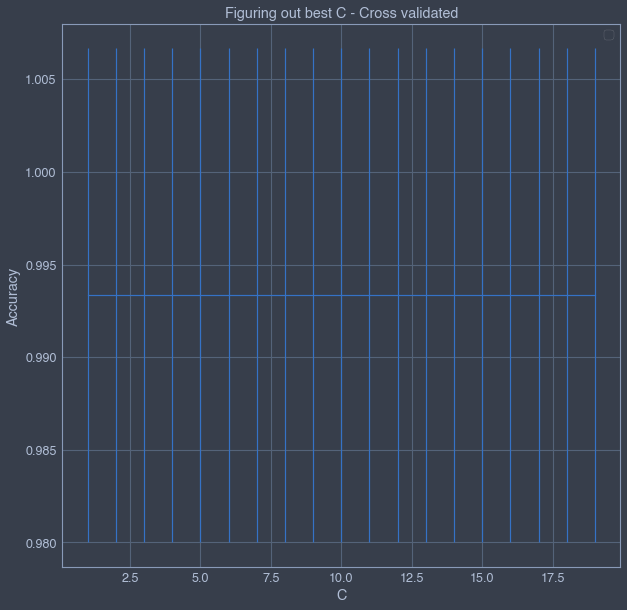

In [15]:
#tento con una cross validation e c nell'arco 0.1, 10
score_mean = []
score_stds = []
Cs = Cs = np.arange(1, 20, 1)
plt.figure(figsize=(10,10))
for c in Cs:
    clf = svm.SVC(C=c, kernel = "poly", gamma="auto")
    scores = cross_val_score(clf, X, y, cv=5)
    score_mean.append(scores.mean())
    score_stds.append(scores.std())

plt.errorbar(Cs, score_mean, yerr = score_stds)
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Figuring out best C - Cross validated")
plt.plot()

**Considerazioni**: c'è un leggero overfitting del modello, ma si può comunque affermare che i risultati sono più che soddisfacienti. La SVM ottiene una accuracy praticamente del 100% sui dati ti training, ovvero riesce a dividere perfettamente l'iperspazio 100-dimensionale. A quanto pare, la divisione dello spazio è molto valida anche per i dati di test, sui quali si riscontra solamente un piccolo errore (si arriva ad ottenere una accuracu sopra il 95%).

È importante notare come, possedendo questi addestramenti elementi stocastici, si dovrebbe procedere eseguendo *k-fold cross validation*.

Dal grafico si può notare come un valore $C > 5$ sia più che soddisfaciente.

## Propagation

**NOTA IMPORTANTE**: per ottenere degli intervalli di confidenza, possiamo usare il Bootstrapping proposto da Hamilton.

In [185]:
# Addestriamo completamente il lessico
inducer = svm.SVC(C = 7, kernel = 'poly', gamma='auto').fit(X,y)

In [28]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [30]:
# We use the trained indecer to predict a label
# for every word in the vocabolary, for all embeddings
models_propagation = [{word: inducer.predict([model.wv[word]])[0] 
  for word in model.wv.vocab} for model in slices.values()]

## Scoring

Qua si vanno a provare diverse tecniche di scoring

### Tecnica 1

In [79]:
# Everything below is done for all embeddings, and 
# put in a list

# This is the sum of the count for every word in the 
# vocabulary times its label. The total sum should be 
# an indication for where the corpus lies (subj or obj)
vocab_counts = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation)]
# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation)]
# The score is given as the counts weighted over the total
# number of words
models_score_1 = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts, vocab_counts_abs)}

In [43]:
print(models_score_1)

{'Wikipedia': -0.9864408736705866, 'ABC News': -0.9540571033325396, 'Slate': -0.9919712460727667, 'Breitbart': -0.9733599047950785, 'CNN': -0.9533930889843204, 'The Federalist': -0.9555784161156244, 'New York Times': -0.9283747165558685, 'News Max': -0.9703698006769811}


In [51]:
{k: v for k, v in sorted(models_score_1.items(), key=lambda item: item[1])}

{'Slate': -0.9919712460727667,
 'Wikipedia': -0.9864408736705866,
 'Breitbart': -0.9733599047950785,
 'News Max': -0.9703698006769811,
 'The Federalist': -0.9555784161156244,
 'ABC News': -0.9540571033325396,
 'CNN': -0.9533930889843204,
 'New York Times': -0.9283747165558685}

### Tecnica 2

In [31]:
models_propagation_2 = [{word: 
                       (inducer.predict([model.wv[word]])[0] + 1)/2
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_2 = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), models_propagation_2)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_2 = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_2, 
                                            vocab_counts_abs)}

In [32]:
print(models_score_2)

{'Wikipedia': 0.00681986185497322, 'ABC News': 0.015299361010535506, 'Breitbart': 0.0107757816307314, 'CNN': 0.012939346831234827, 'The Federalist': 0.017555953264501503, 'New York Times': 0.013159846813249382, 'News Max': 0.011050030926187183}


In [33]:
{k: v for k, v in sorted(models_score_2.items(), key=lambda item: item[1])}

{'Wikipedia': 0.00681986185497322,
 'Breitbart': 0.0107757816307314,
 'News Max': 0.011050030926187183,
 'CNN': 0.012939346831234827,
 'New York Times': 0.013159846813249382,
 'ABC News': 0.015299361010535506,
 'The Federalist': 0.017555953264501503}

## Probabilistico

Per poter usare quello probabilistico, si deve far rigirare tutto l'algoritmo di ML.

In [187]:
# Addestriamo completamente il lessico
inducer = svm.SVC(C = 7, kernel = 'poly', 
                  gamma='auto', probability=True).fit(X,y)

In [188]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [191]:
# Usando predict_proba, si ha la probabilità
# che una parola abbia classe "soggettiva"
models_propagation_prob = [{word: 
                       (inducer.predict_proba([model.wv[word]])[0][1])
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_prob = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), 
                                             models_propagation_prob)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_proba = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_prob, 
                                            vocab_counts_abs)}

In [192]:
{k: v 
 for k, v in sorted(models_score_proba.items(), 
                    key=lambda item: item[1])}

{'Wikipedia': 0.03234006209753735,
 'Breitbart': 0.037542622961439634,
 'News Max': 0.039223327940044746,
 'CNN': 0.04168590050461103,
 'The Federalist': 0.043694972110616626,
 'ABC News': 0.04460527964416759,
 'New York Times': 0.04706819033296307}

# Score Induction - None

Questa tecnica non prevede nessuna propagazione del lessico: si deve prendere quindi il lessico ottenuto dopo la fase di LPR, ovvero in maniera tale che sia condiviso "bene" attraverso tutti gli embedding; e si va a contare tramite questo.

In [34]:
# Load as dictionary the refined lexicon
with open("./lexicon/lexicon_refined.csv", 'r') as file:
    lexicon_refined = pd.read_csv(file, index_col=0).to_dict()["Valence"]

## Scoring

In [35]:
models_propagation_none = [{word: 
                       (lexicon_refined[word]+1)/2
  for word in lexicon_refined} for model in slices.values()]

vocab_counts_none = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in lexicon_refined} 
                for model, model_prop in zip(slices.values(), models_propagation_none)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_none = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_none, 
                                            vocab_counts_abs)}

In [36]:
{k: v 
 for k, v in sorted(models_score_none.items(), 
                    key=lambda item: item[1])}

{'Wikipedia': 0.003270366102405424,
 'New York Times': 0.007333904006972058,
 'Breitbart': 0.00768967455113351,
 'CNN': 0.008429192195132303,
 'News Max': 0.008787206983063569,
 'The Federalist': 0.009193104916872568,
 'ABC News': 0.009348261215619396}

# Score Induction - Hamilton

Nel file ```polarity_induction_methods.py``` ci sono tutte le funzioni di propagazione dello score usate da Hamilton. Quella introdotta da lui, e nota come ```random_walk```, utilizzare un cammino casuale su un grafo di vicinanza per creare le label su tutto il corpus a partire dal lessico raffinato.

## Probabilità

In [201]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [202]:
# We have to remove some nan, because Hamilton sucks
propagations = {filename.split("_")[-1].replace(".csv", ""):
                pd.read_csv(filename, index_col=0).dropna()
                for filename in glob.glob('./propagations/*.csv')}

In [109]:
vocab_counts_Hamilton = {model_name: {row["Words"]: 
                      model.wv.vocab[row["Words"]].count * row["Labels"]
                for index, row in propagations[model_name].iterrows()} 
                for model, model_name in zip(slices.values(), 
                                             slices)}

# This is just the sum of all words in the corpus
vocab_counts_abs = {model_name: {word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_name in zip(slices.values(), 
                                                 slices)}
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: 
                         (sum(vocab_counts_Hamilton[name].values())
                          /(sum(vocab_counts_abs[name].values())))
                         for name in slices}

In [110]:
{k: v 
 for k, v in sorted(models_score_Hamilton.items(), 
                    key=lambda item: item[1])}

{'News Max': 0.27288266728822386,
 'New York Times': 0.35008134971567084,
 'The Federalist': 0.3892598204880916,
 'Wikipedia': 0.4220568869485383,
 'ABC News': 0.4261976874144494,
 'Breitbart': 0.4517553687816639,
 'CNN': 0.4808339932163405}

## Valori Certi

In [116]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [170]:
# We have to remove some nan, because Hamilton sucks
propagations = {filename.split("_")[-1].replace(".csv", ""):
                pd.read_csv(filename, index_col=0).dropna()
                for filename in glob.glob('./propagations/*.csv')}

In [171]:
# Assegnameno un threshold alle probabilità
THRESHOLD = 0.5
for name in propagations:
    propagations[name].loc[propagations[name]["Labels"] < THRESHOLD, "Labels"] = 0
    propagations[name].loc[propagations[name]["Labels"] >= THRESHOLD, "Labels"] = 1

In [172]:
vocab_counts_Hamilton = {model_name: {row["Words"]: 
                      model.wv.vocab[row["Words"]].count * row["Labels"]
                for index, row in propagations[model_name].iterrows()} 
                for model, model_name in zip(slices.values(), 
                                             slices)}

# This is just the sum of all words in the corpus
vocab_counts_abs = {model_name: {word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_name in zip(slices.values(), 
                                                 slices)}
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_Hamilton = {name: 
                         (sum(vocab_counts_Hamilton[name].values())
                          /(sum(vocab_counts_abs[name].values())))
                         for name in slices}

In [173]:
{k: v 
 for k, v in sorted(models_score_Hamilton.items(), 
                    key=lambda item: item[1])}

{'News Max': 0.17229893924336245,
 'New York Times': 0.2097396846079913,
 'The Federalist': 0.3208121561148533,
 'ABC News': 0.3546656363756502,
 'Wikipedia': 0.4217181738563238,
 'Breitbart': 0.4377185414891586,
 'CNN': 0.4697929498521115}

# Examples

In [203]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}
# We have to remove some nan, because Hamilton sucks
propagations = {filename.split("_")[-1].replace(".csv", ""):
                pd.read_csv(filename, index_col=0).dropna()
                for filename in glob.glob('./propagations/*.csv')}

In [251]:
len([el for el in list(lexicon_refined.values()) if el == 1])

11

In [252]:
len([el for el in list(lexicon_refined.values()) if el == -1])

58

In [253]:
models_propagation = [{word: inducer.predict([model.wv[word]])[0] 
  for word in model.wv.vocab} for model in slices.values()]

In [301]:
initial_subj = [key for key, el in lexicon_refined.items() if el == 1]

In [302]:
initial_subj.extend(list(np.zeros(12)))
initial_subj = ["z" if el == 0 else el for el in initial_subj ]

In [303]:
prop_subj = [[key for key, val in models_propagation[i].items() if val == 1]
                for i in range(7)]


In [304]:
for sj in prop_subj:
    print("-----------\n\n")
    for x,y in zip(sorted(initial_subj), sorted(sj)):
        print(x, y)

-----------


best after
court although
despite best
great can
like caused
little court
long despite
need due
right great
though like
will little
z long
z must
z right
z though
z will
-----------


best best
court can
despite court
great despite
like great
little if
long like
need little
right long
though lot
will must
z need
z right
z though
z want
z will
-----------


best can
court court
despite despite
great if
like like
little long
long need
need right
right though
though want
will will
-----------


best amid
court best
despite can
great court
like despite
little great
long if
need like
right little
though long
will lot
z need
z right
z though
z want
z will
-----------


best best
court can
despite court
great despite
like great
little if
long like
need little
right long
though lot
will must
z need
z no
z right
z though
z want
z will
-----------


best amid
court best
despite better
great can
like can’t
little court
long despite
need going
right great
though if
will judge
z like


In [228]:
example_words = ["good", "obama", "dog", 
                 "immigrant", "left", "pleasure", 
                "best", "will", "like"]

In [229]:

for word in example_words:
    print("####", word, "####")
    for name in propagations:
        print("\t",name)
        print("\t\tNicoli:", inducer.predict_proba([slices[name].wv[word]])[0][1])
        print("\t\tHamilton:", propagations[name]["Labels"].loc[(propagations[name]["Words"] 
                                                   == word)].values[0])
    print('\n\n')

#### good ####
	 Wikipedia
		Nicoli: 0.005720136308740902
		Hamilton: 0.0034194483058794553
	 Breitbart
		Nicoli: 0.029593523772480215
		Hamilton: 0.0008545665134493114
	 New York Times
		Nicoli: 0.03465035254066715
		Hamilton: 0.008813351064437001
	 News Max
		Nicoli: 0.008554864929359855
		Hamilton: 0.0009160580707994806
	 CNN
		Nicoli: 0.015589932102866126
		Hamilton: 0.0533449516863327
	 The Federalist
		Nicoli: 0.0013282211817761415
		Hamilton: 0.00011735544543223877
	 ABC News
		Nicoli: 0.0026857888521870624
		Hamilton: 0.0055244519406016865



#### obama ####
	 Wikipedia
		Nicoli: 0.02265400360866403
		Hamilton: 0.5750019210201982
	 Breitbart
		Nicoli: 0.02335130475232244
		Hamilton: 0.5400325705783007
	 New York Times
		Nicoli: 0.020869245850530488
		Hamilton: 0.2733529726819154
	 News Max
		Nicoli: 0.019990780355327337
		Hamilton: 0.7393664261575884
	 CNN
		Nicoli: 0.020974728658858386
		Hamilton: 0.21596244734023207
	 The Federalist
		Nicoli: 0.02003764605942378
		Hamilton: 0

# Nicoli Logistic

## Machine Learning Optimization

In [306]:
# Open the pre-prepared lexicon
with open("./lexicon/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)

In [307]:
# Read the strings as lists
enriched_lexicon["Vectorized_words"] = enriched_lexicon["Vectorized_words"].apply(literal_eval)

In [308]:
# Prepare a list of 100-dimension vectors (the words)
X = enriched_lexicon["Vectorized_words"].tolist()
# List of labels (1, -1)
y = enriched_lexicon["Labels"]

No handles with labels found to put in legend.


[]

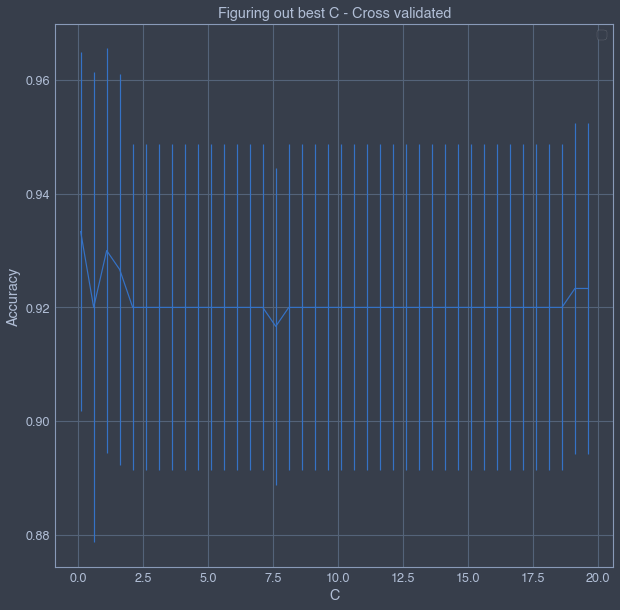

In [316]:
#tento con una cross validation e c nell'arco 0.1, 10
score_mean = []
score_stds = []
Cs = Cs = np.arange(0.1, 20, 0.5)
plt.figure(figsize=(10,10))
for c in Cs:
    clf = LogisticRegression(C=c, penalty='l2', solver='liblinear')
    scores = cross_val_score(clf, X, y, cv=5)
    score_mean.append(scores.mean())
    score_stds.append(scores.std())

plt.errorbar(Cs, score_mean, yerr = score_stds)
plt.legend()
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Figuring out best C - Cross validated")
plt.plot()

## Propagation

In [317]:
# Addestriamo completamente il lessico
inducer = LogisticRegression(C=10, penalty='l2', solver='liblinear').fit(X,y)

## Scoring

In [318]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [326]:
models_propagation_test = [{word: 
                       (inducer.predict([model.wv[word]])[0] + 1)/2
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_test = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), models_propagation_test)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_test = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_test, 
                                            vocab_counts_abs)}

In [327]:
{k: v for k, v in sorted(models_score_test.items(), key=lambda item: item[1])}

{'Breitbart': 0.30067150021700856,
 'The Federalist': 0.3277963323093111,
 'Wikipedia': 0.33049939046396515,
 'CNN': 0.33578883075856175,
 'News Max': 0.36872493762639774,
 'ABC News': 0.3812641862091579,
 'New York Times': 0.4127322858990402}

## Testing

In [325]:
prop_subj = [[key for key, val in models_propagation_test[i].items() if val == 1]
                for i in range(7)]
print([len(model)for model in prop_subj])

[5645, 2913, 1436, 2176, 3008, 4939, 1555]


# Nicoli NB

## Machine Learning Optimization

In [328]:
# Open the pre-prepared lexicon
with open("./lexicon/enriched_lexicon.csv", 'r') as file:
    enriched_lexicon = pd.read_csv(file, 
                                   engine='c', 
                                   index_col=0)

In [329]:
# Read the strings as lists
enriched_lexicon["Vectorized_words"] = enriched_lexicon["Vectorized_words"].apply(literal_eval)

In [333]:
# Prepare a list of 100-dimension vectors (the words)
X = enriched_lexicon["Vectorized_words"].tolist()
# List of labels (1, -1)
y = enriched_lexicon["Labels"]

In [335]:
#tento con una cross validation e c nell'arco 0.1, 10
score_mean = []
score_stds = []
plt.figure(figsize=(10,10))

clf = GaussianNB()
scores = cross_val_score(clf, X, y, cv=5)
score_mean.append(scores.mean())
score_stds.append(scores.std())

# plt.errorbar(Cs, score_mean, yerr = score_stds)
# plt.legend()
# plt.xlabel("C")
# plt.ylabel("Accuracy")
# plt.title("Figuring out best C - Cross validated")
# plt.plot()

<Figure size 720x720 with 0 Axes>

In [338]:
scores.std()

0.02357022603955158

## Propagation

In [340]:
# Addestriamo completamente il lessico
inducer = GaussianNB().fit(X,y)

## Scoring

In [341]:
slices = {filename.split('/')[-1].replace(".model", ""): 
          Word2Vec.load(filename)
          for filename in glob.glob('./models/*.model')}

In [342]:
models_propagation_test = [{word: 
                       (inducer.predict([model.wv[word]])[0] + 1)/2
  for word in model.wv.vocab} for model in slices.values()]

vocab_counts_test = [{word: model.wv.vocab[word].count * model_prop[word]
                for word in model.wv.vocab} 
                for model, model_prop in zip(slices.values(), models_propagation_test)]

# This is just the sum of all words in the corpus
vocab_counts_abs = [{word: abs(model.wv.vocab[word].count)
                    for word in model.wv.vocab}  
                    for model, model_prop in zip(slices.values(), 
                                                 models_propagation_test)]
# Difatti questa misure dice quante parole soggettive ci sono
# per singola parola scritta nei vari corpus.
models_score_test = {name: sum(count.values())/(sum(count_abs.values()))
                for name, count, count_abs in zip(slices, vocab_counts_test, 
                                            vocab_counts_abs)}

In [343]:
{k: v for k, v in sorted(models_score_test.items(), key=lambda item: item[1])}

{'Wikipedia': 0.047936614093317814,
 'Breitbart': 0.0634518118349114,
 'News Max': 0.0671925276772001,
 'The Federalist': 0.08038985654293847,
 'CNN': 0.08922372345707988,
 'ABC News': 0.11014299893693666,
 'New York Times': 0.11501674687633125}

## Testing

In [344]:
prop_subj = [[key for key, val in models_propagation_test[i].items() if val == 1]
                for i in range(7)]
print([len(model)for model in prop_subj])

[139, 168, 69, 114, 108, 209, 79]
